# Examples of pyiron_nodes applications

### Setup environment and import modules 

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path(Path.cwd()).parent))
# sys.path

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%config IPCompleter.evaluation='unsafe'

### Create and run a simple workflow (plot trigonometric functions)

Note: The nodes in math and plotting have been created with an LLM and using aider

{'plot_sin__axis': <Axes: title={'center': 'sin(x)'}>,
 'plot_cos__axis': <Axes: title={'center': 'cos(x)'}>,
 'plot_tan__axis': <Axes: title={'center': 'tan(x)'}>,
 'plot_arcsin__axis': <Axes: title={'center': 'arcsin(x)'}>,
 'plot_arccos__axis': <Axes: title={'center': 'arccos(x)'}>,
 'plot_arctan__axis': <Axes: title={'center': 'arctan(x)'}>}

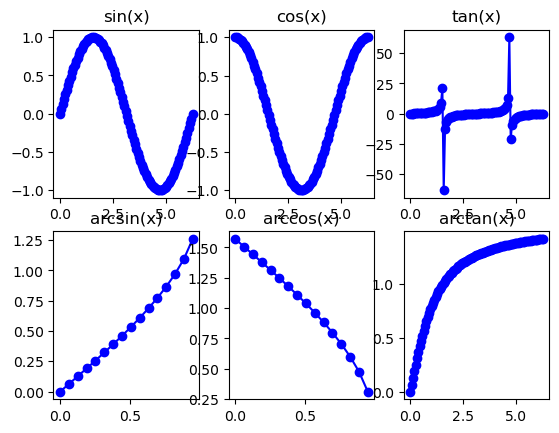

In [4]:
from pyiron_workflow import Workflow

# Register the necessary node packages                                                                        
Workflow.register("pyiron_nodes.math", "math")
Workflow.register("pyiron_nodes.plotting", "plotting")

# Create a new workflow                                                                                       
wf = Workflow("trigonometric_functions")

# Create a Linspace node to generate a vector  
import numpy as np

wf.linspace = wf.create.plotting.Linspace(start=0, stop=2 * np.pi, num=100)

# Create nodes for each trigonometric function                                                                
wf.sin = wf.create.math.Sin(x=wf.linspace)
wf.cos = wf.create.math.Cos(x=wf.linspace)
wf.tan = wf.create.math.Tan(x=wf.linspace)
wf.arcsin = wf.create.math.Arcsin(x=wf.linspace)
wf.arccos = wf.create.math.Arccos(x=wf.linspace)
wf.arctan = wf.create.math.Arctan(x=wf.linspace)

# Create a subplot node                                                                                       
wf.subplot = wf.create.plotting.Subplot(nrows=2, ncols=3)

# Create plot nodes for each trigonometric function                                                           
wf.plot_sin = wf.create.plotting.Plot(x=wf.linspace, y=wf.sin, axis=wf.subplot[0, 0], title='sin(x)')
wf.plot_cos = wf.create.plotting.Plot(x=wf.linspace, y=wf.cos, axis=wf.subplot[0, 1], title='cos(x)')
wf.plot_tan = wf.create.plotting.Plot(x=wf.linspace, y=wf.tan, axis=wf.subplot[0, 2], title='tan(x)')
wf.plot_arcsin = wf.create.plotting.Plot(x=wf.linspace, y=wf.arcsin, axis=wf.subplot[1, 0], title='arcsin(x)')
wf.plot_arccos = wf.create.plotting.Plot(x=wf.linspace, y=wf.arccos, axis=wf.subplot[1, 1], title='arccos(x)')
wf.plot_arctan = wf.create.plotting.Plot(x=wf.linspace, y=wf.arctan, axis=wf.subplot[1, 2], title='arctan(x)')

# Execute the workflow                                                                                        
wf()


### Pyiron atomistic examples

### Create a supercell

In [5]:
from pyiron_workflow import Workflow                                                                        
                                                                                                         
# Register the necessary node packages                                                                      
Workflow.register("pyiron_nodes.atomistic", "atomistic")                                        
                                                                                                         
# Create a new workflow                                                                                     
wf = Workflow("bulk_structure")                                                                             
                                                                                                         
# Create a cubic_bulk node to generate an aluminum cubic supercell of size 3x3x3                                                              
wf.supercell = wf.create.atomistic.structure.build.cubic_bulk_cell(element='Al', cell_size=3)
                                                                                                         
# Execute the workflow                                                                                      
out = wf() 

In [6]:
wf.outputs.supercell__structure.value.plot3d(particle_size=3)

NGLWidget()

### Compute supercell energy

In [7]:
from pyiron_workflow import Workflow                
               
# Register the necessary node packages 
Workflow.register("pyiron_nodes.atomistic", "atomistic") 
                      
# Create a new workflow  
wf = Workflow("bulk_structure") 
   
# Create a cubic_bulk node to generate an aluminum cubic supercell of size 3x3x3 with vacancy at atom index 0
wf.supercell = wf.create.atomistic.structure.build.cubic_bulk_cell(element='Al', cell_size=3, vacancy_index=0)
wf.calc = wf.create.atomistic.calculator.ase.minimize(structure=wf.supercell)
                     
# Execute the workflow
out = wf()

print (f"total energy: {wf.calc.outputs.out.final.energy.value}")

total energy: 0.7996059979213581


In [8]:
wf.supercell.bulk.outputs.structure.value.plot3d(particle_size=3)

NGLWidget()

In [9]:
wf.calc.outputs.out.final.energy.value

0.7996059979213581

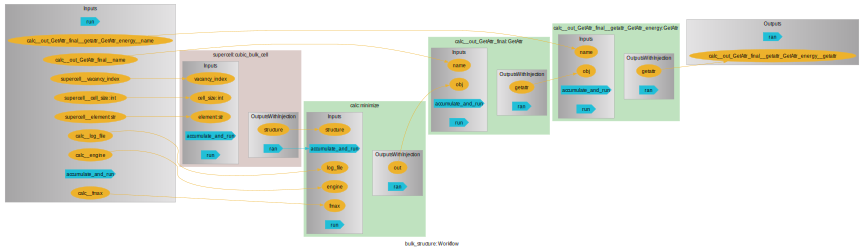

In [10]:
wf.draw(size=(12,15))

### Compute vacancy formation energy

In [11]:
from pyiron_workflow import Workflow                
               
# Register the necessary node packages 
Workflow.register("pyiron_nodes.atomistic", "atomistic") 
                      
# Create a new workflow  
wf = Workflow("bulk_structure") 
   
# Create a cubic_bulk node to generate an aluminum cubic supercell of size 3x3x3 with vacancy at atom index 0
wf.supercell = wf.create.atomistic.structure.build.cubic_bulk_cell(element='Al', cell_size=3, vacancy_index=0)
wf.calc = wf.create.atomistic.calculator.ase.minimize(structure=wf.supercell)
                     
# Execute the workflow
out = wf()

def compute_vacancy_formation_energy(pure_bulk_energy, defective_bulk_energy, n_atoms_in_pure_bulk_cell):
    mu = pure_bulk_energy / n_atoms_in_pure_bulk_cell
    return defective_bulk_energy - pure_bulk_energy + mu

# Compute the energy of a pure bulk cell
pure_bulk_wf = Workflow("pure_bulk")
pure_bulk_wf.supercell = pure_bulk_wf.create.atomistic.structure.build.cubic_bulk_cell(element='Al', cell_size=3)
pure_bulk_wf.calc = pure_bulk_wf.create.atomistic.calculator.ase.minimize(structure=pure_bulk_wf.supercell)
pure_bulk_out = pure_bulk_wf()

# Compute the vacancy formation energy
n_atoms_in_pure_bulk_cell = pure_bulk_wf.create.atomistic.structure.calc.number_of_atoms(pure_bulk_wf.supercell).run()
vacancy_formation_energy = compute_vacancy_formation_energy(pure_bulk_wf.calc.outputs.out.final.energy.value, wf.calc.outputs.out.final.energy.value, n_atoms_in_pure_bulk_cell)
print(f"vacancy formation energy: {vacancy_formation_energy}")


vacancy formation energy: 0.9603250896481503


### Use another engine

In [12]:
from pyiron_workflow import Workflow

Workflow.register("pyiron_nodes.atomistic", "atomistic") 

wf = Workflow('M3GNet')
wf.engine = Workflow.create.atomistic.engine.ase.M3GNet()
wf.get_chem_pot = Workflow.create.atomistic.property.thermodynamics.get_chemical_potential('W', engine=wf.engine)

wf.run()

{'get_chem_pot__chemical_potential': -12.87940788269043}

### Compute Elastic Constants

#### Single point calculation

In [13]:
from pyiron_workflow import Workflow

wf = Workflow("elastic_constants") 
atomistic = Workflow.create.atomistic
from pyiron_nodes.atomistic.property.elastic import InputElasticTensor

wf.engine = atomistic.engine.ase.M3GNet() 
wf.supercell = atomistic.structure.build.cubic_bulk_cell(element='Al', cell_size=3, vacancy_index=0)
wf.calc = atomistic.calculator.ase.static(structure=wf.supercell, engine=wf.engine)
wf.elastic = atomistic.property.elastic.elastic_constants(structure=wf.supercell, engine=wf.engine, parameters=InputElasticTensor(eps_range=0.01))
out = wf.run()

print (f'Bulkmodulus: {out.elastic__elastic.BV} GPa')

/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


Bulkmodulus: 53.492619696968546 GPa


/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


#### Parametric study

In [14]:
atomistic = Workflow.create.atomistic
from pyiron_nodes.atomistic.property.elastic import InputElasticTensor

@Workflow.wrap.as_macro_node('BV')
def compute_elastic_constants(wf, element='Fe', parameters=InputElasticTensor(eps_range=0.02)): # eps_range=0.01):
    
    wf.engine = atomistic.engine.ase.M3GNet() #.run()
    wf.supercell = atomistic.structure.build.cubic_bulk_cell(element=element, cell_size=3, vacancy_index=0)
    wf.calc = atomistic.calculator.ase.static(structure=wf.supercell, engine=wf.engine)
    wf.elastic = atomistic.property.elastic.elastic_constants(structure=wf.supercell, engine=wf.engine, parameters=parameters)
    return wf.elastic.outputs.elastic.BV
    
out = compute_elastic_constants(element='Ni').run() #iter(eps_range=np.linspace(1e-4, 1, 11))
out

/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


{'BV': 207.853238427253}

In [15]:
out

{'BV': 207.853238427253}

In [16]:
# compute_elastic_constants().iter(element=['Al', 'Ni', 'Fe'], parameters=[InputElasticTensor(eps_range=0.01), InputElasticTensor(eps_range=0.02)])

In [17]:
%%time
#compute_elastic_constants().iter(element=['Al', 'Ni', 'Fe'], parameters=[InputElasticTensor(eps_range=eps) for eps in [0.001, 0.01, 0.02, 0.1]])

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 1.91 μs


### Compute phonons

#### Workflow

/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['rotations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['translations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['wyckoffs']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joe

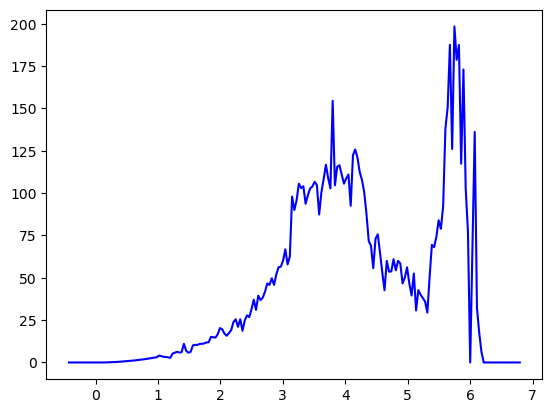

In [18]:
from pyiron_workflow import Workflow

wf = Workflow("phonons") 
atomistic = Workflow.create.atomistic
from pyiron_nodes.atomistic.property.phonons import InputPhonopyGenerateSupercells

wf.engine = atomistic.engine.ase.M3GNet() #.run()
wf.supercell = atomistic.structure.build.cubic_bulk_cell(element='Al', cell_size=3, vacancy_index=0)
wf.calc = atomistic.calculator.ase.static(structure=wf.supercell, engine=wf.engine)
wf.phonon = atomistic.property.phonons.create_phonopy(structure=wf.supercell, 
                                                      engine=wf.engine,
                                                      parameters=InputPhonopyGenerateSupercells())
# wf.check = atomistic.property.phonons.check_consistency(phonopy=wf.phonon.outputs.phonopy)
wf.phonon_dos = atomistic.property.phonons.get_total_dos(phonopy=wf.phonon.outputs.phonopy)
wf.plot_dos = Workflow.create.plotting.Plot(x=wf.phonon_dos.frequency_points, 
                                            y=wf.phonon_dos.total_dos, 
                                            symbol='', 
                                            title='phonon dos')

out = wf.run()

Access output data directly:

In [19]:
wf.phonon_dos.outputs.total_dos.value

,frequency_points,total_dos
0,-0.428462,0.0
1,-0.392339,0.0
2,-0.356215,0.0
3,-0.320092,0.0
4,-0.283969,0.0
...,...,...
196,6.651711,0.0
197,6.687834,0.0
198,6.723958,0.0
199,6.760081,0.0


#### Rewrite workflow as macro

In [20]:
from pyiron_workflow import Workflow

wf = Workflow("phonons") 
atomistic = Workflow.create.atomistic
from pyiron_nodes.atomistic.property.phonons import InputPhonopyGenerateSupercells

@Workflow.wrap.as_macro_node('phonon_dos_plot')
def plot_phonon_dos(wf, element='Fe', cell_size=1, parameters=InputPhonopyGenerateSupercells()):
    wf.engine = atomistic.engine.ase.M3GNet() #.run()
    wf.supercell = atomistic.structure.build.cubic_bulk_cell(element=element, cell_size=3, vacancy_index=0)
    wf.calc = atomistic.calculator.ase.static(structure=wf.supercell, engine=wf.engine)
    wf.phonon = atomistic.property.phonons.create_phonopy(structure=wf.supercell, 
                                                          engine=wf.engine,
                                                          parameters=InputPhonopyGenerateSupercells())
    
    wf.phonon_dos = atomistic.property.phonons.get_total_dos(phonopy=wf.phonon.outputs.phonopy)
    wf.plot_dos = Workflow.create.plotting.Plot(x=wf.phonon_dos.frequency_points, 
                                                y=wf.phonon_dos.total_dos, 
                                                symbol='', 
                                                title='phonon dos')
    return wf.plot_dos

/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['rotations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['translations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg

,element,phonon_dos_plot
0,Al,<module 'matplotlib.pyplot' from '/Users/joerg...
1,Fe,<module 'matplotlib.pyplot' from '/Users/joerg...


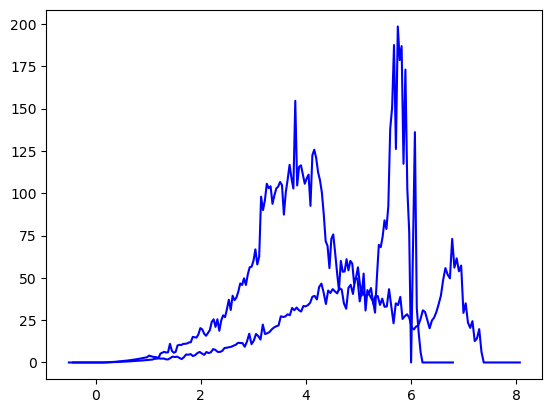

In [21]:
plot_phonon_dos().iter(element=['Al', 'Fe'])

TODO: change colors and add label

/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['rotations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['translations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg/miniforge3/envs/py12/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/joerg

,parameters,phonon_dos_plot
0,"InputPhonopyGenerateSupercells(distance=0.1, i...",<module 'matplotlib.pyplot' from '/Users/joerg...
1,"InputPhonopyGenerateSupercells(distance=0.01, ...",<module 'matplotlib.pyplot' from '/Users/joerg...
2,"InputPhonopyGenerateSupercells(distance=0.001,...",<module 'matplotlib.pyplot' from '/Users/joerg...


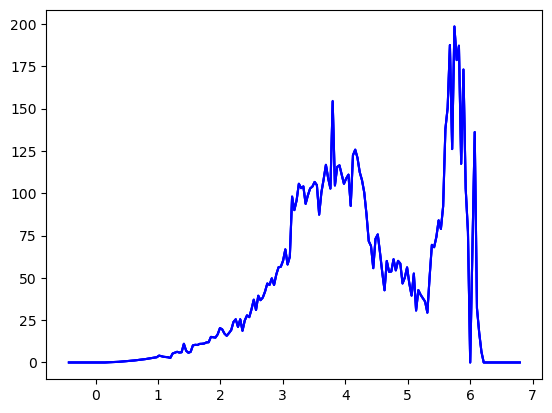

In [22]:
plot_phonon_dos(element='Al').iter(parameters=[InputPhonopyGenerateSupercells(distance=d) for d in [0.1, 0.01, 0.001]])

### Wishlist

- capture errors in iter (return na ratther than stop)
- provide iter capability inside workflows/macros
- unpack data_classes in iter dataframe
- show docstrings (with shift tab) for node functions (presently I get only 'Docstring:     
A mix-in to make class-factory-produced classes pickleable.' ...)

- dataclass: (reduce it to a single decorator, i.e., remove need for second line)
```python    
@Workflow.wrap.as_dataclass_node
@dataclass 
```
- provide a simple way to transfer it as list of **kwargs to function call
- provide option to add original function from where to take the docstring info (for the last two points see comparison below) 

### Comparison of the data classes

#### My implementation

In [23]:
from pyiron_nodes.dev_tools import wf_data_class
from typing import Optional, Union

from phonopy.api_phonopy import Phonopy


@wf_data_class(doc_func=Phonopy.generate_displacements)
class InputPhonopyGenerateSupercells:
    distance: float = 0.01
    is_plusminus: Union[str, bool] = "auto"
    is_diagonal: bool = True
    is_trigonal: bool = False
    number_of_snapshots: Optional[int] = None
    random_seed: Optional[int] = None
    temperature: Optional[float] = None
    cutoff_frequency: Optional[float] = None
    max_distance: Optional[float] = None

**Note:** Behaves like a dict, e.g.

In [24]:
dc = InputPhonopyGenerateSupercells()
dc.keys()

dict_keys(['distance', 'is_plusminus', 'is_diagonal', 'is_trigonal', 'number_of_snapshots', 'random_seed', 'temperature', 'cutoff_frequency', 'max_distance'])

#### Liam's implementation

In [25]:
from dataclasses import dataclass, field

@Workflow.wrap.as_dataclass_node
@dataclass
class InputPhonopyGenerateSupercells:
    distance: float = 0.01
    is_plusminus: Union[str, bool] = "auto"
    is_diagonal: bool = True
    is_trigonal: bool = False
    number_of_snapshots: Optional[int] = None
    random_seed: Optional[int] = None
    temperature: Optional[float] = None
    cutoff_frequency: Optional[float] = None
    max_distance: Optional[float] = None

In [26]:
dc = InputPhonopyGenerateSupercells()

In [27]:
dc.dataclass.distance

0.01

In [28]:
dc.outputs

In [29]:
out = dc.run()
out

InputPhonopyGenerateSupercells(distance=0.01, is_plusminus='auto', is_diagonal=True, is_trigonal=False, number_of_snapshots=None, random_seed=None, temperature=None, cutoff_frequency=None, max_distance=None)